We are going to explore the method of Layerwise Relevance Propagation to identify which features are most important in the decision process of the IN. The details of the LRP method can be found in [this paper](https://doi.org/10.1007/978-3-030-28954-6_10). The original LRP rule has been developed for simple networks like MLPs. For a classification problem, the total relevance score is taken as the netowrk's output for the corresponding class. This relevance score is propagated back to the previous layers following the LRP rule-

\begin{equation}
r_j^{(n)} = \frac{a_j^{(n)}w_{jk:n}}{\sum_k a_j^{(n)}w_{jk:n}}r_k^{(n+1)}
\end{equation}

here $a_j^{(n)}$ and $r_j^{(n)}$ are the activation and relevance scores of the $j$-th node in $n$-th layer and $w_{jk:n}$ is the weight that determines the contribution of the $j$-th activation in the $n$-th layer to the $k$-th node in layer $n+1$. This rule is called the LRP-0 rule, since it uses the exact values for the weights and activations without any regularization.

We'll start by setting up the code and loading the baseline model.

In [99]:
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from gnn import GraphNetnoSV
from gnn import GraphNet
from gnn import GraphNetAllParticle
from data import H5Data
import glob
import json
import torch.nn as nn
import os
from matplotlib import colors

params = ['track_ptrel',
          'track_erel',
          'track_phirel',
          'track_etarel',
          'track_deltaR',
          'track_drminsv',
          'track_drsubjet1',
          'track_drsubjet2',
          'track_dz',
          'track_dzsig',
          'track_dxy',
          'track_dxysig',
          'track_normchi2',
          'track_quality',
          'track_dptdpt',
          'track_detadeta',
          'track_dphidphi',
          'track_dxydxy',
          'track_dzdz',
          'track_dxydz',
          'track_dphidxy',
          'track_dlambdadz',
          'trackBTag_EtaRel',
          'trackBTag_PtRatio',
          'trackBTag_PParRatio',
          'trackBTag_Sip2dVal',
          'trackBTag_Sip2dSig',
          'trackBTag_Sip3dVal',
          'trackBTag_Sip3dSig',
          'trackBTag_JetDistVal'
         ]

params_sv = ['sv_ptrel',
          'sv_erel',
          'sv_phirel',
          'sv_etarel',
          'sv_deltaR',
          'sv_pt',
          'sv_mass',
          'sv_ntracks',
          'sv_normchi2',
          'sv_dxy',
          'sv_dxysig',
          'sv_d3d',
          'sv_d3dsig',
          'sv_costhetasvpv'
         ]

def_state_dict = torch.load('IN_training/gnn_new_DR0_best.pth')

for key in def_state_dict.keys():
    print(key, def_state_dict[key].shape)

batch_size = 128
Ntracks = 60
Nverts = 5
hidden = 60
Nclasses = 2
De = 20
Do = 24
files = glob.glob("dataset/train/newdata_*.h5")
files_val = files[:5] # take first 5 for validation
data_val = H5Data(batch_size = batch_size,
                  cache = None,
                  preloading=0,
                  features_name='training_subgroup',
                  labels_name='target_subgroup',
                  spectators_name='spectator_subgroup')
data_val.set_file_names(files_val)

gnn_0 = GraphNet(Ntracks, Nclasses, len(params), hidden, Nverts, len(params_sv),
                 vv_branch=0,
                 De=De,
                 Do=Do)

gnn_0.load_state_dict(def_state_dict)
softmax = torch.nn.Softmax(dim=1)


fr1.weight torch.Size([60, 60])
fr1.bias torch.Size([60])
fr2.weight torch.Size([60, 60])
fr2.bias torch.Size([60])
fr3.weight torch.Size([20, 60])
fr3.bias torch.Size([20])
fr1_pv.weight torch.Size([60, 44])
fr1_pv.bias torch.Size([60])
fr2_pv.weight torch.Size([60, 60])
fr2_pv.bias torch.Size([60])
fr3_pv.weight torch.Size([20, 60])
fr3_pv.bias torch.Size([20])
fo1.weight torch.Size([60, 70])
fo1.bias torch.Size([60])
fo2.weight torch.Size([60, 60])
fo2.bias torch.Size([60])
fo3.weight torch.Size([24, 60])
fo3.bias torch.Size([24])
fc_fixed.weight torch.Size([2, 24])
fc_fixed.bias torch.Size([2])


Now let's define the method to calculate the LRP scores. The same method is expected to generate all variants of the LRP algorithm, the LRP-0 rule mentioned above as well as the LRP-$\epsilon$ and LRP-$\gamma$ rules.

In [100]:
def LRP(Rin, weights, biases, activations, debug = False, include_bias = False, 
        mode = 'zero', eps = 1.0, gamma = 2.0, beta = 1.0, extend_dendrop = False, 
        dendrop_threshold = 1.):
    ## expected sizes:
    ## Rin : (Nb, N_next, N_candidates)
    ## weights : (N_prev, N_next)
    ## biases: (N_next)
    ## activations: (Nb, N_prev, N_candidates)
    ## returns Rout: (Nb, N_prev, N_candidates)
    # eps = 0.25 * torch.std(Rin, dim=(0,2), unbiased = False)
    # print(eps)
    ## creating denominator 
    ## shape (N_prev, N_next).T * (Nb, N_prev, N_candidates) + (N_next, 1) = (Nb, N_next, N_candidates)
    
    #print(mode)
    if mode not in ['zero', 'eps', 'gamma', 'gamma+', 'gamma-', 'ab']:
        print("Unrecognized mode! Defaulting to LRP-0")
        mode = 'zero'
    
    alpha = beta + 1
    if mode == 'gamma+' or mode == 'gamma':
        weights = weights + gamma*torch.ones(weights.shape, device='cuda')*(weights > 0)
    elif mode == 'gamma-':
        weights = weights + gamma*torch.ones(weights.shape, device='cuda')*(weights <= 0)
    elif mode == 'ab':
        weights = weights + alpha*torch.ones(weights.shape, device='cuda')*(weights > 0) + \
                             beta*torch.ones(weights.shape, device='cuda')*(weights <= 0)
    if debug:
        print("\nNext layer relevances sum", Rin.sum())
        print("Next layer relevances size", Rin.size())
        print("Weight matrix size", weights.size())
        print("Biases size", biases.size())
        print("Prev layer activation size", activations.size())
    
    denominator = torch.matmul(torch.transpose(weights, 0, 1), activations)  + \
                  include_bias*biases.reshape(-1,1)
    denominator[denominator == 0] = eps/10.
    if mode == 'eps':
        denominator += eps*torch.sign(denominator)
    
    if extend_dendrop:
        dendropat = dendrop_threshold
    else:
        dendropat = 0.    
    den2drop = torch.abs(denominator) <= dendropat
    
    if debug:
        print("Denominator drop threshold", dendropat)
        print("How many denominators are zero?", torch.sum(den2drop).item())
        print("Cumulative relevance of zeroed instances:", Rin[den2drop].sum().item())
    
    if True:
        fs_Rin = Rin.sum().item()/(Rin.sum().item() - Rin[den2drop].sum().item())
        if debug:
            print("Rescaling Factor for Rin:", fs_Rin)
        Rin[den2drop] = 0.0
        denominator[den2drop] = 1.0
        Rin = Rin * fs_Rin
    
    
    scaledR = Rin / denominator
    Rout = torch.matmul(weights, scaledR) * activations
    if debug:
        print("Prev layer relevances size", Rout.size())
        print("Prev layer relevances sum", Rout.sum(), "\n")
    return Rout

While the rule of propagation across MLP layers is well defined, we need to also figure out how to redistribute the relevances across the following operations that have been exclusively defined for the IN model.

First, to propagate the relevances for the operation of summing internal representation of track features obtained from the aggregator network $(O_{[D_o \times N_p]} \rightarrow \bar{O}_{[D_o]})$, we'll use the following relation-

\begin{equation}
r_{kn} = \bar{r}_k\frac{o_{kn}}{\bar{o}_{k}}
\end{equation}

where $\bar{r}$ represents the LRP scores for the summed internal representation.

Second, the interaction matrices $R_R$ and $R_K$ propagate edge level internal space representation to the individual particle tracks $({E}_{pp}[D_e \times N_{pp}] \rightarrow \bar{E}_{pp}[D_e \times N_{p}]$ and ${E}_{vp}[D_e \times N_{vp}] \rightarrow \bar{E}_{vp}[D_e \times N_{p}] )$. To propagate the relevances across these operations, we'll use the relation-

\begin{equation}
r_{km} = e_{km}\sum_n\frac{\bar{r}_{kn}}{\bar{e}_{kn}}R_{R/K, nm}
\end{equation}


In [101]:
def LRPEvaluator(model, x, y, weighted_firing=False, debug = False, target = 0,
                 LRP_mode = 'eps', eps = 1.0, gamma = 1.0, beta = 1.0, dendrop_threshold = 0.):
    
    Nb = x.shape[0]
    particle_relevances = torch.zeros(x.shape)
    vertex_relevances = torch.zeros(y.shape)
    target = int(target)
    hidden_relevance = []
    tags = []
    
    if debug:
        print("target = ", target)
    
    FiringEvaluator = []
    layer_tags = []
    ###PF Candidate - PF Candidate###
    Orr = model.tmul(x, model.Rr)
    Ors = model.tmul(x, model.Rs)
    B = torch.cat([Orr, Ors], 1)
    ### First MLP ###
    B = torch.transpose(B, 1, 2).contiguous()
    B1 = nn.functional.relu(model.fr1(B.view(-1, 2 * model.P + model.Dr)))
    B2 = nn.functional.relu(model.fr2(B1))    
    E = nn.functional.relu(model.fr3(B2))
    E = E.view(-1, model.Nr, model.De)    
    Epp = torch.transpose(E, 1, 2).contiguous()
    Ebar_pp = model.tmul(Epp, torch.transpose(model.Rr, 0, 1).contiguous())
    del E

    ####Secondary Vertex - PF Candidate### 
    Ork = model.tmul(x, model.Rk)
    Orv = model.tmul(y, model.Rv)
    Bpv = torch.cat([Ork, Orv], 1)
    ### First MLP ###
    Bpv = torch.transpose(Bpv, 1, 2).contiguous()
    Bpv1 = nn.functional.relu(model.fr1_pv(Bpv.view(-1, model.S + model.P + model.Dr)))
    Bpv2 = nn.functional.relu(model.fr2_pv(Bpv1))
    E = nn.functional.relu(model.fr3_pv(Bpv2))
    E = E.view(-1, model.Nt, model.De)
    
    # del B
    Epv = torch.transpose(E, 1, 2).contiguous()
    Ebar_pv = model.tmul(Epv, torch.transpose(model.Rk, 0, 1).contiguous())
    Ebar_vp = model.tmul(Epv, torch.transpose(model.Rv, 0, 1).contiguous())
    del E

    ####Final output matrix for particles###
    C = torch.cat([x, Ebar_pp, Ebar_pv], 1)
    C = torch.transpose(C, 1, 2).contiguous()
    ### Second MLP ###
    C1 = nn.functional.relu(model.fo1(C.view(-1, model.P + model.Dx + (2 * model.De))))
    C2 = nn.functional.relu(model.fo2(C1))
    O = nn.functional.relu(model.fo3(C2))
    O = O.view(-1, model.N, model.Do)

    # del C

    #Taking the sum of over each particle/vertex
    N_in = torch.sum(O, dim=1).reshape(Nb, 1, model.Do)
    #del O
    
    ### Classification MLP ###
    N_out = model.fc_fixed(N_in)
    
    ######## This is where we start calculating the LRP for for different layers
    
    ## First calculating the total relevance of the desired jet class
    Relevances = N_out[:, :, target].reshape(Nb, 1, -1)
    
    
    ## step-1: relevance for fc_fixed
    if debug:
        print("\nDoing LRP for fc_fixed)")

    rel_fc_fixed = LRP(Rin = Relevances, 
                       weights = torch.transpose(def_state_dict['fc_fixed.weight'], 0, 1)[:, target].reshape(-1,1), 
                       biases = def_state_dict['fc_fixed.bias'][target].reshape(-1), 
                       activations = torch.transpose(N_in, 1, 2), 
                       debug = debug,
                       mode = LRP_mode,
                       eps = eps,
                       gamma = gamma,
                       include_bias = False)
    
    hidden_relevance.append((rel_fc_fixed/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fo3')
    
    ## step-2: relevance propagation from O_bar -> O
    
    O = torch.transpose((O + 0)/(N_in + 1.e-5), 1, 2)
    if debug:
        print("\nActivation distribution shape", O.shape)
        print(O[:, 0:5, :])
        print(torch.sum(O[:, 0:5, :], dim=2))
    rel_O = rel_fc_fixed * O
    
    if debug:
        print("\nFixed FC size after sum", rel_fc_fixed.size())
        print(rel_fc_fixed.reshape(-1))
        print("Fixed FC size before sum", rel_O.size())
        print("Fixed FC relevance before sum", rel_O.sum())
        print("Fo:", rel_O.max(), rel_O.min())
    
    ## step-3: relevance propagation across fo
    
    if debug:
        print("\nDoing LRP for fo")

    rel_fo3 = LRP(Rin = rel_O, 
                  weights = torch.transpose(def_state_dict['fo3.weight'], 0, 1), 
                  biases = def_state_dict['fo3.bias'], 
                  activations = torch.transpose(C2.reshape(Nb, model.N, model.hidden), 1, 2), 
                  debug = debug,
                  mode = LRP_mode,
                  gamma = gamma,
                  eps = eps )
    
    hidden_relevance.append((rel_fo3/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fo2')
    
    if debug:
        print("fo3", rel_fo3.max(), rel_fo3.min())
        
    rel_fo2 = LRP(Rin = rel_fo3, 
                  weights = torch.transpose(def_state_dict['fo2.weight'], 0, 1), 
                  biases = def_state_dict['fo2.bias'], 
                  activations = torch.transpose(C1.reshape(Nb, model.N, model.hidden), 1, 2), 
                  debug = debug,
                  mode = LRP_mode,
                  gamma = gamma,
                  eps = eps)
    
    hidden_relevance.append((rel_fo2/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fo1')
    
    if debug:
        print("fo2", rel_fo2.max(), rel_fo2.min())
    
    rel_fo1 = LRP(Rin = rel_fo2, 
                  weights = torch.transpose(def_state_dict['fo1.weight'], 0, 1), 
                  biases = def_state_dict['fo1.bias'], 
                  activations = torch.transpose(C, 1, 2), 
                  debug = debug,
                  mode = LRP_mode,
                  gamma = gamma,
                  eps = eps)
    
    if debug:
        print("fo1", rel_fo1.max(), rel_fo1.min())
    
    ## Step-4: relevance redistribution for Interaction Matrices
    
    rel_Epp = rel_fo1[:, model.P:model.P+model.De, :] 
    rel_Epv = rel_fo1[:, model.P+model.De:model.P+2*model.De, :] 
    particle_relevances = particle_relevances + \
                          (rel_fo1[:, :model.P, :]/Relevances.reshape(Nb,1,1)).detach().cpu()
    
    if debug:
        print("\nParticle Relevances Sum: ", particle_relevances.sum())
        print("Particle Relevances Max: ", particle_relevances.max())
        print("Particle Relevances Min: ", particle_relevances.min())
        
    
    if debug:
        print("\nrel_Epp shape before IN: ", rel_Epp.size())
        print("rel_Epp sum before IN: ", rel_Epp.sum())
        print("rel_Epv shape before IN: ", rel_Epv.size())
        print("rel_Epv sum before IN: ", rel_Epv.sum())
        print("Remaining relevance sum before IN: ", rel_fo1[:, :model.P, :].sum())
        print("Ebar_pp shape:", Ebar_pp.shape)
        print("Epp shape:", Epp.shape)
        print("Ebar_pv shape:", Ebar_pv.shape)
        print("Epv shape:", Epv.shape)

    Ebar_pp = torch.transpose(C, 1, 2)[:, model.P:model.P+model.De, :] 
    Ebar_pv = torch.transpose(C, 1, 2)[:, model.P+model.De:model.P+2*model.De, :]
    rel_Epp = torch.matmul(rel_Epp/(Ebar_pp + 1.e-5), model.Rr) * Epp
    rel_Epv = torch.matmul(rel_Epv/(Ebar_pv + 1.e-5), model.Rk) * Epv
    
    
    
    if debug:
        print("\nEpp relevance shape after IN: ", rel_Epp.size())
        print("Epv relevance shape after IN: ", rel_Epv.size())
        print("Epp relevance sum before IN: ", rel_Epp.sum())
        print("Epv relevance sum before IN: ", rel_Epv.sum())
        print("Epp", rel_Epp.max(), rel_Epp.min())
        print("Epv", rel_Epv.max(), rel_Epv.min())
        
    if debug:
        print("\nDoing LRP for fr")
    
    
    ## Step-5: relevance distribution across fr network (PC-PC)
    
    
    hidden_relevance.append((rel_Epp/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fr3')

    rel_fr3 = LRP(Rin = rel_Epp, 
                  weights = torch.transpose(def_state_dict['fr3.weight'], 0, 1), 
                  biases = def_state_dict['fr3.bias'], 
                  activations = torch.transpose(B2.reshape(Nb, model.Nr, model.hidden), 1, 2), 
                  debug = debug,
                  mode = LRP_mode,
                  gamma = gamma,
                  eps = eps)
    if debug:
        print("fr3", rel_fr3.max(), rel_fr3.min())
        
    hidden_relevance.append((rel_fr3/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fr2')

    
    rel_fr2 = LRP(Rin = rel_fr3, 
                  weights = torch.transpose(def_state_dict['fr2.weight'], 0, 1), 
                  biases = def_state_dict['fr2.bias'], 
                  activations = torch.transpose(B1.reshape(Nb, model.Nr, model.hidden), 1, 2), 
                  debug = debug,
                  mode = LRP_mode,
                  gamma = gamma,
                  eps = eps)
    
    if debug:
        print("fr2", rel_fr2.max(), rel_fr2.min())
    
    
    hidden_relevance.append((rel_fr2/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fr1')

    
    rel_fr1 = LRP(Rin = rel_fr2, 
                  weights = torch.transpose(def_state_dict['fr1.weight'], 0, 1), 
                  biases = def_state_dict['fr1.bias'], 
                  activations = torch.transpose(B, 1, 2), 
                  debug = debug,
                  extend_dendrop = True,
                  dendrop_threshold = dendrop_threshold,
                  mode = LRP_mode,
                  gamma = gamma,
                  eps = eps)
    
    if debug:
        print("fr1", rel_fr1.max(), rel_fr1.min())
    
    
    ## Step-6: relevance distribution across Rr and Rs network matrices (PC-PC)
    
    
    rel_Rr = rel_fr1[:,:model.P,:]
    rel_Rs = rel_fr1[:,model.P:,:]
    if debug:
        print("\nRr relevance shape before IN: ", rel_Rr.size())
        print("Rs relevance shape before IN: ", rel_Rs.size())
        print("Rr relevance sum before IN: ", rel_Rr.sum())
        print("Rs relevance sum before IN: ", rel_Rs.sum())
        
    rel_Rr = torch.matmul(rel_Rr, torch.transpose(model.Rr, 0, 1))
    rel_Rs = torch.matmul(rel_Rs, torch.transpose(model.Rs, 0, 1))
    
    if debug:
        print("\nRr relevance shape after IN: ", rel_Rr.size())
        print("Rs relevance shape after IN: ", rel_Rs.size())
        print("Rr relevance sum after IN: ", rel_Rr.sum())
        print("Rs relevance sum after IN: ", rel_Rs.sum())
        print("rel_Rr", rel_Rr.max(), rel_Rr.min())
        print("rel_Rs", rel_Rs.max(), rel_Rs.min())
    
    particle_relevances = particle_relevances + \
                          (rel_Rr/Relevances.reshape(Nb,1,1)).detach().cpu()  + \
                          (rel_Rs/Relevances.reshape(Nb,1,1)).detach().cpu()
    
    if debug:
        print("\nParticle Relevances Sum: ", particle_relevances.sum())
    
    
    ## Step-7: relevance distribution across fr_pv network (PC-SV)
    
    if debug:
        print("\nDoing LRP for fr_pv")
        
        
    hidden_relevance.append((rel_Epv/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fr3_pv')
    
    rel_fr3_pv = LRP(Rin = rel_Epv, 
                     weights = torch.transpose(def_state_dict['fr3_pv.weight'], 0, 1), 
                     biases = def_state_dict['fr3_pv.bias'], 
                     activations = torch.transpose(Bpv2.reshape(Nb, model.Nt, model.hidden), 1, 2), 
                     debug = debug,
                     mode = LRP_mode,
                     gamma = gamma,
                     eps = eps)
    
    hidden_relevance.append((rel_fr3_pv/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fr2_pv')
    
    rel_fr2_pv = LRP(Rin = rel_fr3_pv, 
                     weights = torch.transpose(def_state_dict['fr2_pv.weight'], 0, 1), 
                     biases = def_state_dict['fr2_pv.bias'], 
                     activations = torch.transpose(Bpv1.reshape(Nb, model.Nt, model.hidden), 1, 2), 
                     debug = debug,
                     mode = LRP_mode,
                     gamma = gamma,
                     eps = eps)
    
    hidden_relevance.append((rel_fr2_pv/Relevances.reshape(Nb,1,1)).sum(dim=(0,2)).detach().cpu().numpy())
    tags.append('fr1_pv')
    
    rel_fr1_pv = LRP(Rin = rel_fr2_pv, 
                     weights = torch.transpose(def_state_dict['fr1_pv.weight'], 0, 1), 
                     biases = def_state_dict['fr1_pv.bias'], 
                     activations = torch.transpose(Bpv, 1, 2), 
                     debug = debug,
                     extend_dendrop = True,
                     dendrop_threshold = dendrop_threshold,
                     mode = LRP_mode,
                     gamma = gamma,
                     eps = eps)
    
    
    ## Step-8: relevance distribution across Rr and Rs network matrices (PC-PC)
    
    rel_Rk = rel_fr1_pv[:,:model.P,:]
    rel_Rv = rel_fr1_pv[:,model.P:,:]
    if debug:
        print("\nRk relevance shape before IN: ", rel_Rk.size())
        print("Rv relevance shape before IN: ", rel_Rv.size())
        print("Rk relevance sum before IN: ", rel_Rk.sum())
        print("Rv relevance sum before IN: ", rel_Rv.sum())
    rel_Rk = torch.matmul(rel_fr1_pv[:,:model.P,:], torch.transpose(model.Rk, 0, 1))
    rel_Rv = torch.matmul(rel_fr1_pv[:,model.P:,:], torch.transpose(model.Rv, 0, 1))
    
    if debug:
        print("\nRk relevance shape after IN: ", rel_Rk.size())
        print("Rv relevance shape after IN: ", rel_Rv.size())
        print("Rk relevance sum after IN: ", rel_Rk.sum())
        print("Rv relevance sum after IN: ", rel_Rv.sum())
        
    particle_relevances = particle_relevances + (rel_Rk/Relevances.reshape(Nb,1,1)).detach().cpu()
    vertex_relevances = vertex_relevances + (rel_Rv/Relevances.reshape(Nb,1,1)).detach().cpu()
    
    if debug:
        print("\nParticle Relevances Sum: ", particle_relevances.sum())
        print("Vertex Relevances Sum: ", vertex_relevances.sum())
        print("Outsput shape:", N_out.shape)

    return N_out, particle_relevances, vertex_relevances, hidden_relevance, tags

Now we will explore the average LRP scores for input features. We use the LRP-$\gamma$ method with $\gamma = 2.0$. Other choices can be explore by changing the relevant variables in the code snippet below.

In [102]:
Pall_0 = []
Vall_0 = []
Pall_1 = []
Vall_1 = []
count_0 = 0
count_1 = 0
idx = 0
nmax = 30
debug = False
LRP_mode = 'gamma'
eps = 0.4
gamma = 2.
dendrop_threshold = gamma if LRP_mode == 'gamma' else 0.
tag = LRP_mode + ('_{}'.format(eps) if LRP_mode == 'eps' else ('_{}'.format(gamma) if LRP_mode == 'gamma' else ''))
HiddenRelevance_0 = []
HiddenRelevance_1 = []
with torch.no_grad():
    for sub_X,sub_Y,sub_Z in data_val.generate_data():
        training = sub_X[2]
        training_sv = sub_X[3]
        target = sub_Y[0]
        spec = sub_Z[0]
        trainingv = (torch.FloatTensor(training)).cuda()
        _, inds = torch.sort(torch.tensor(trainingv[:,1,:]), descending=True) # descending order of rel_e
        for ii in range(trainingv.shape[0]):
            trainingv[ii] = trainingv[ii][:,inds[ii]]
        trainingv_sv = (torch.FloatTensor(training_sv)).cuda()
        _, inds = torch.sort(torch.tensor(trainingv_sv[:,5,:]), descending=True) # descending order of sv_pt
        for ii in range(trainingv_sv.shape[0]):
            trainingv_sv[ii] = trainingv_sv[ii][:,inds[ii]]
        
        keep_indices = target[:,1] == 0
        
        if keep_indices.sum().item() > 0:
            N, P, V, H, tags = LRPEvaluator(model = gnn_0, 
                                            x = trainingv[keep_indices, :, :], 
                                            y = trainingv_sv[keep_indices, :, :],
                                            target = 0,
                                            debug = debug,
                                            LRP_mode = LRP_mode,
                                            eps = eps,
                                            gamma = gamma,
                                            dendrop_threshold = dendrop_threshold)
            print("Batch: {}, target: 0, count = {}, Psum = {}, Vsum = {}".format(idx, N.shape[0], 
                                                                                  P.sum().item(),
                                                                                  V.sum().item())) 
            # Pall_0 += P.detach().cpu()
            # Vall_0 += V.detach().cpu()
            Pall_0.append(P.detach().cpu())
            Vall_0.append(V.detach().cpu())
            count_0 += keep_indices.sum().item()
            if idx == 0:
                for hr in H:
                    HiddenRelevance_0.append(hr)
            else:
                for ii, hr in enumerate(H):
                    HiddenRelevance_0[ii] += hr
        keep_indices = target[:,1] == 1
        if keep_indices.sum().item() > 0:
            N, P, V, H, tags = LRPEvaluator(model = gnn_0, 
                                            x = trainingv[keep_indices, :, :], 
                                            y = trainingv_sv[keep_indices, :, :],
                                            target = 1,
                                            debug = debug,
                                            LRP_mode = LRP_mode,
                                            eps = eps,
                                            gamma = gamma,
                                            dendrop_threshold = dendrop_threshold)
        
            print("Batch: {}, target: 1, count = {}, Psum = {}, Vsum = {}".format(idx, N.shape[0], 
                                                                                  P.sum().item(),
                                                                                  V.sum().item()))
            # Pall_1 += P.detach().cpu()
            # Vall_1 += V.detach().cpu()
            Pall_1.append(P.detach().cpu())
            Vall_1.append(V.detach().cpu())
            count_1 += keep_indices.sum().item()
            if idx == 0:
                for hr in H:
                    HiddenRelevance_1.append(hr)
            else:
                for ii, hr in enumerate(H):
                    HiddenRelevance_1[ii] += hr
            
        idx += 1
        if idx == nmax:
            break

/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/avroy/.conda/envs/avroy_py37/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Batch: 0, target: 0, count = 80, Psum = 65.58647918701172, Vsum = 14.398040771484375
Batch: 0, target: 1, count = 48, Psum = 36.12527084350586, Vsum = 11.88650131225586
Batch: 1, target: 0, count = 94, Psum = 77.12635040283203, Vsum = 16.706390380859375
Batch: 1, target: 1, count = 34, Psum = 25.83598518371582, Vsum = 8.161396026611328
Batch: 2, target: 0, count = 97, Psum = 79.78286743164062, Vsum = 17.113405227661133
Batch: 2, target: 1, count = 31, Psum = 23.55280303955078, Vsum = 7.4142165184021
Batch: 3, target: 0, count = 71, Psum = 58.787723541259766, Vsum = 11.545875549316406
Batch: 3, target: 1, count = 57, Psum = 41.04896545410156, Vsum = 16.047870635986328
Batch: 4, target: 0, count = 90, Psum = 74.90306854248047, Vsum = 14.947601318359375
Batch: 4, target: 1, count = 38, Psum = 28.355915069580078, Vsum = 9.575079917907715
Batch: 5, target: 0, count = 82, Psum = 68.00785064697266, Vsum = 14.134794235229492
Batch: 5, target: 1, count = 46, Psum = 34.90077209472656, Vsum = 11.

Now we'll separate the scores for the two jet categories.

In [103]:
Pall_0 = torch.cat(Pall_0).sum(dim = 0)/count_0 # track scores for QCD
Pall_1 = torch.cat(Pall_1).sum(dim = 0)/count_1 # track scores for Hbb
Vall_0 = torch.cat(Vall_0).sum(dim = 0)/count_0 # vertex scores for QCD
Vall_1 = torch.cat(Vall_1).sum(dim = 0)/count_1 # vertex scores for QCD

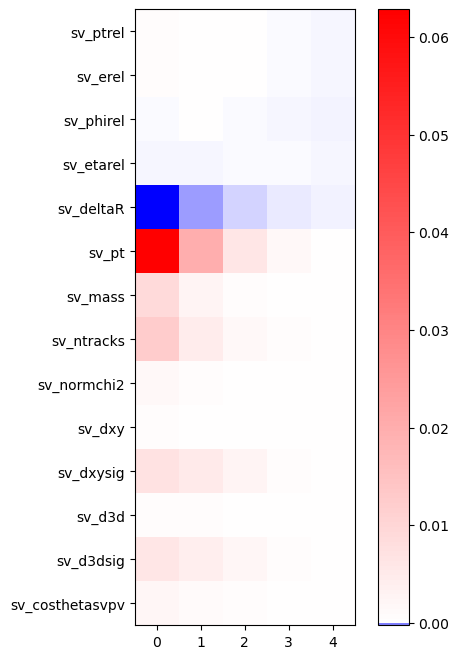

In [104]:
plt.figure(figsize=(6,8))
divnorm=colors.TwoSlopeNorm(vmin=min(Vall_0.min(),0), vcenter=max(Vall_0.min(),0)+1.e-5, vmax=Vall_0.max())
plt.imshow(Vall_0.numpy(), cmap='bwr', interpolation='None', norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params_sv)), labels = params_sv)
plt.savefig("plots_xAI/sv0_LRP_{}.png".format(tag), bbox_inches='tight')
plt.show()

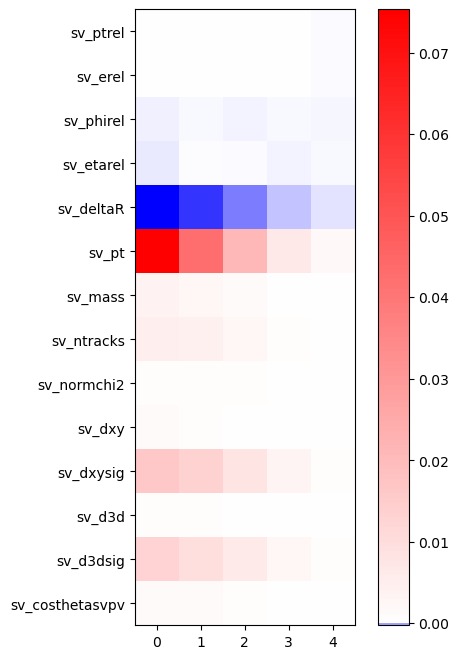

In [105]:
plt.figure(figsize=(6,8))
divnorm=colors.TwoSlopeNorm(vmin=min(Vall_1.min(),0), vcenter=max(Vall_1.min(),0)+1.e-5, vmax=Vall_1.max())
plt.imshow(Vall_1.numpy(), cmap='bwr', interpolation='None', norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params_sv)), labels = params_sv)
plt.savefig("plots_xAI/sv1_LRP_{}.png".format(tag), bbox_inches='tight')
plt.show()

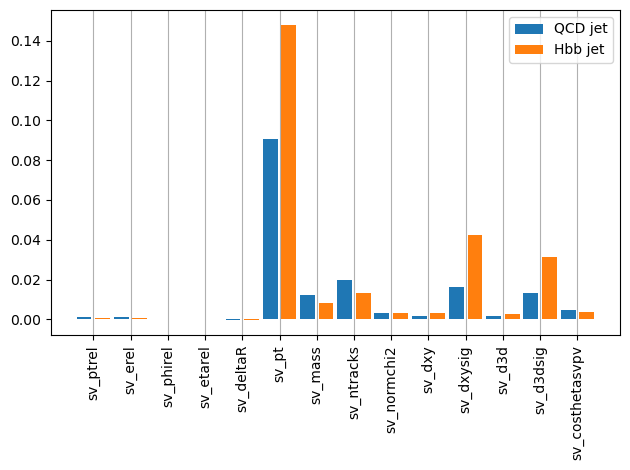

In [106]:
pos = 2*np.arange(len(params_sv))
plt.bar(pos, torch.sum(Vall_0, 1).numpy(), align='center', label='QCD jet')
plt.bar(pos + 1, torch.sum(Vall_1, 1).numpy(), align='center', label='Hbb jet')
plt.xticks(pos+0.5, params_sv, rotation='vertical')
plt.legend()
plt.grid(axis='x')
plt.tight_layout()
plt.savefig("plots_xAI/sv_feats_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

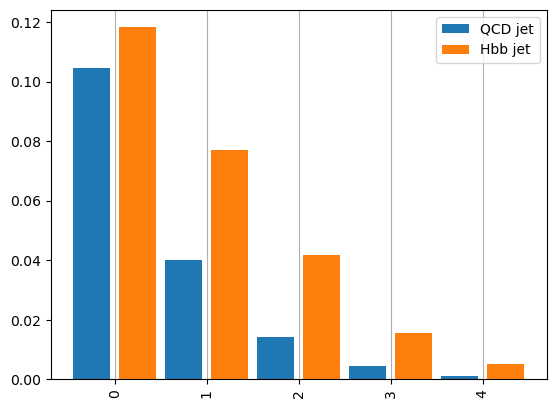

In [107]:
pos = 2*np.arange(5)
plt.bar(pos, torch.sum(Vall_0, 0).numpy(), align='center', label = 'QCD jet')
plt.bar(pos + 1, torch.sum(Vall_1, 0).numpy(), align='center', label = 'Hbb jet')
plt.xticks(pos + 0.5, list(map(int, pos/2)), rotation='vertical')
plt.grid(axis='x')
plt.legend()
plt.savefig("plots_xAI/sv_vertices_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

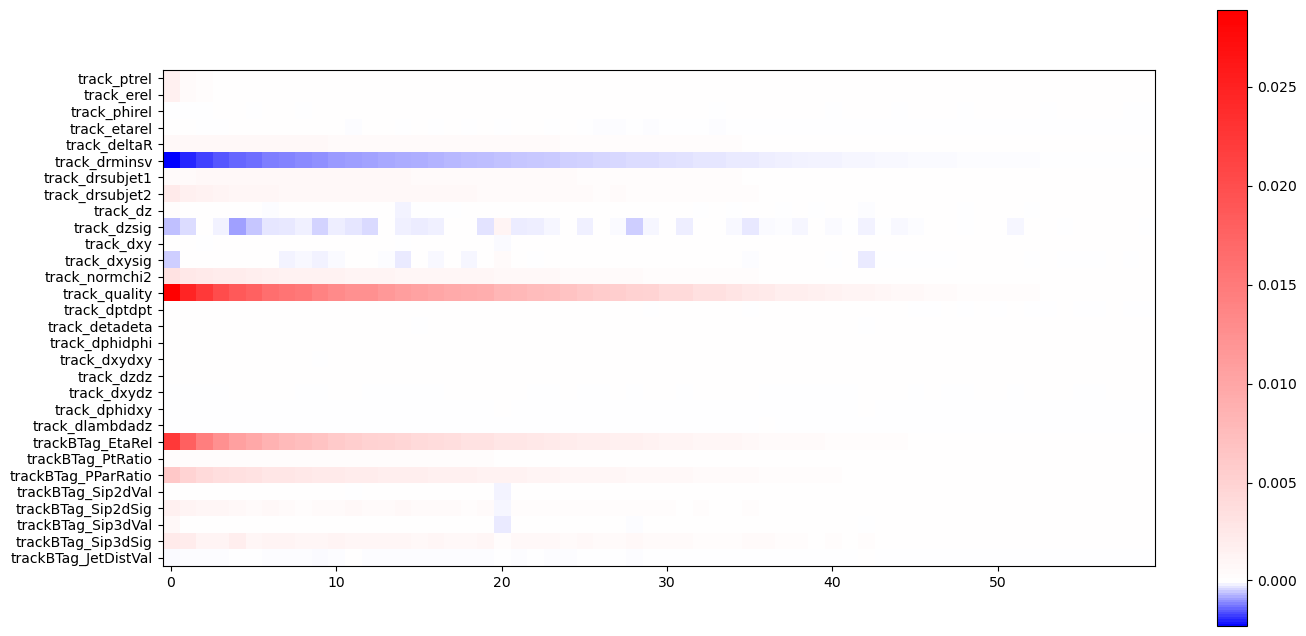

In [108]:
plt.figure(figsize=(16,8))
divnorm=colors.TwoSlopeNorm(vmin=Pall_0.min(), vcenter=0., vmax=Pall_0.max())
plt.imshow(Pall_0.numpy(), cmap='bwr', interpolation='None', norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params)), labels = params)
plt.savefig("plots_xAI/track0_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

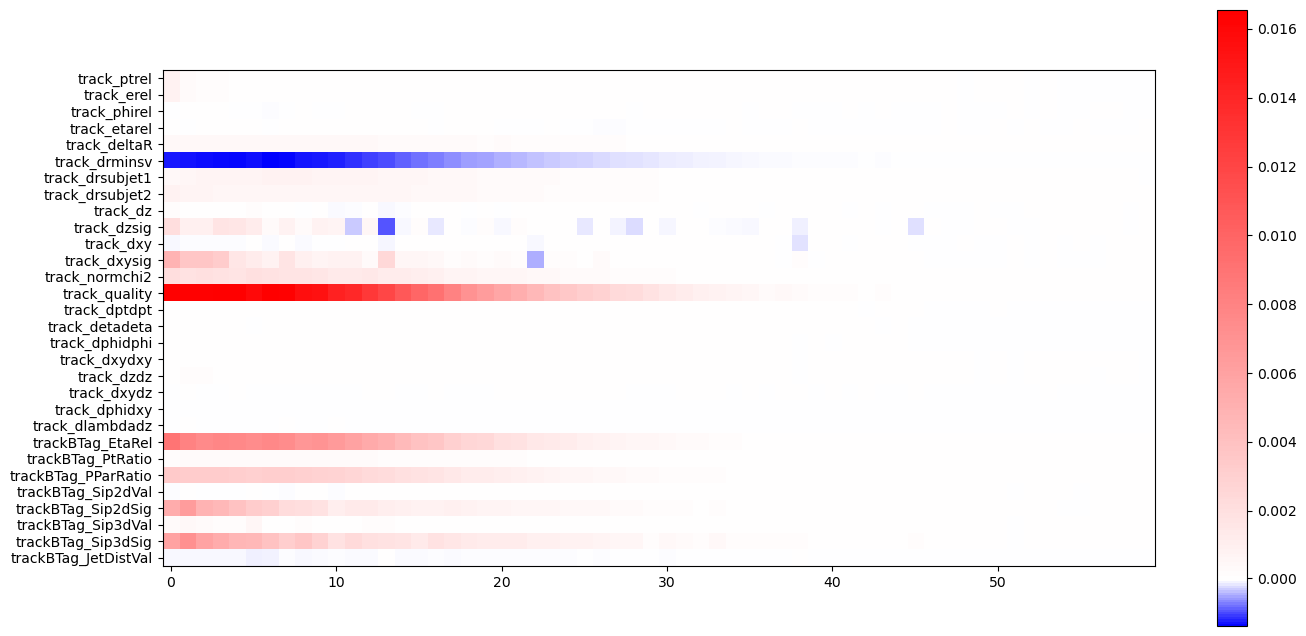

In [109]:
plt.figure(figsize=(16,8))
divnorm=colors.TwoSlopeNorm(vmin=Pall_1.min(), vcenter=0., vmax=Pall_1.max())
plt.imshow(Pall_1.numpy(), cmap='bwr', interpolation='None', norm=divnorm)
plt.colorbar()
plt.yticks(range(len(params)), labels = params)
plt.savefig("plots_xAI/track1_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

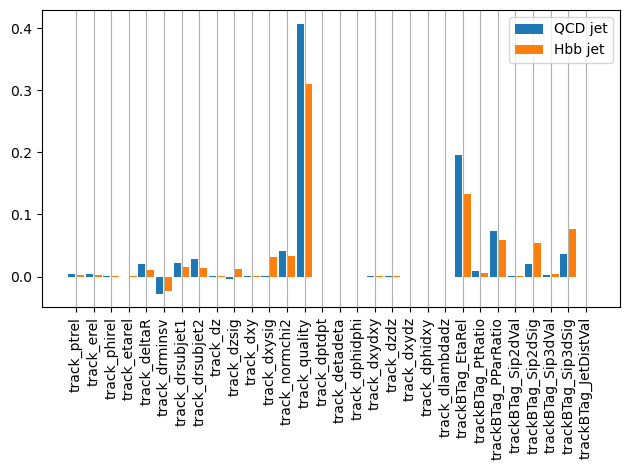

In [110]:
pos = 2*np.arange(len(params))
plt.bar(pos, torch.sum(Pall_0, 1).numpy(), align='center', label = 'QCD jet')
plt.bar(pos + 1, torch.sum(Pall_1, 1).numpy(), align='center', label = 'Hbb jet')
plt.xticks(pos + 0.5, params, rotation='vertical')
plt.grid(axis='x')
plt.legend()
plt.tight_layout()
plt.savefig("plots_xAI/track_feats_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

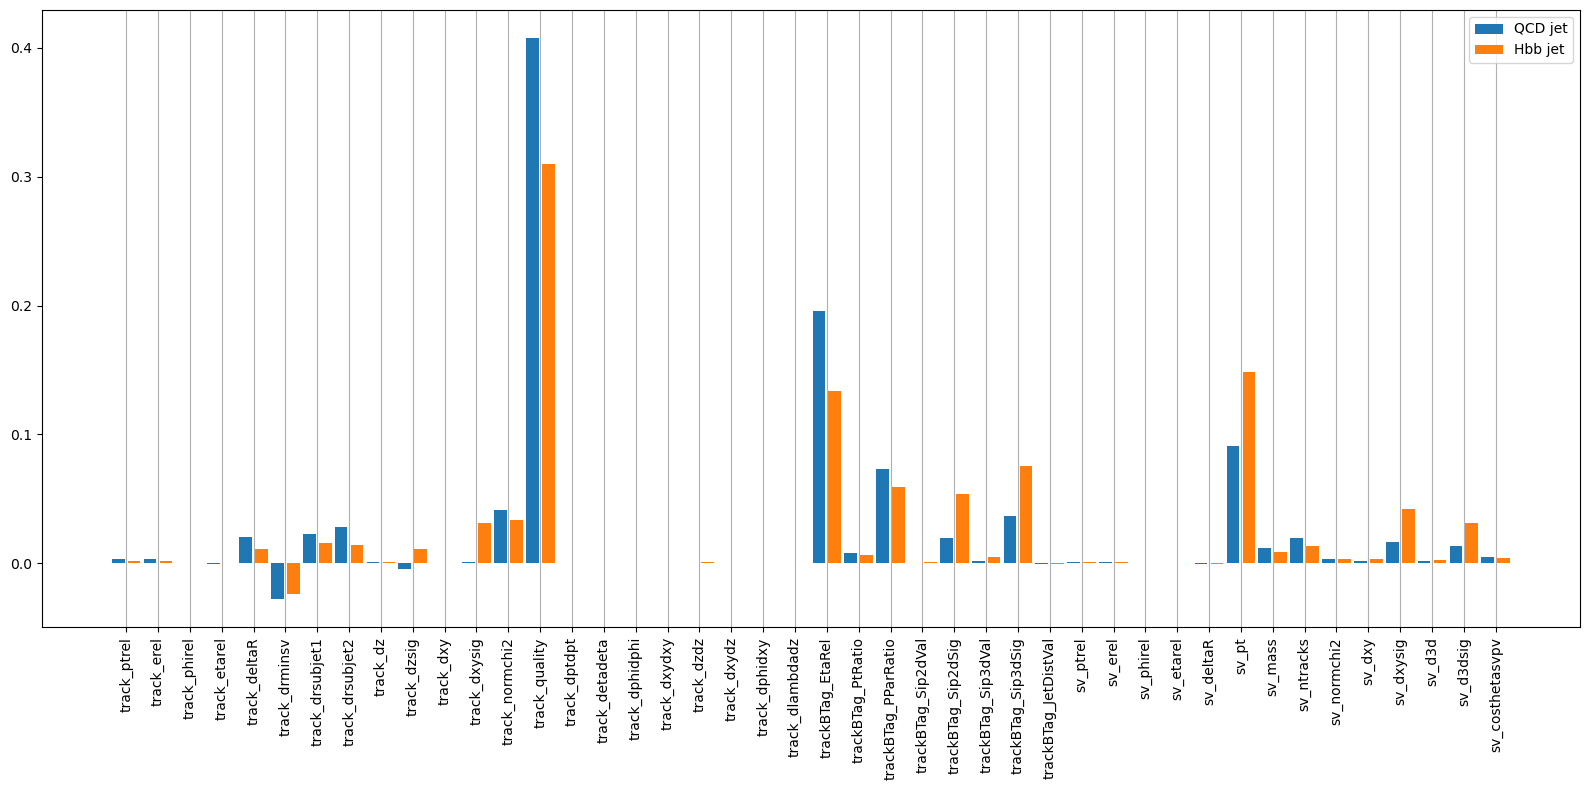

In [111]:
pos = 2*np.arange(len(params) + len(params_sv))
plt.figure(figsize=(16,8))
plt.bar(pos, 
        np.append(torch.sum(Pall_0, 1).numpy(), torch.sum(Vall_0, 1).numpy()),
        align='center', label = 'QCD jet')
plt.bar(pos + 1, 
        np.append(torch.sum(Pall_1, 1).numpy(), torch.sum(Vall_1, 1).numpy()),
        align='center', label = 'Hbb jet')
plt.xticks(pos + 0.5, params + params_sv, rotation='vertical')
plt.grid(axis='x')
plt.legend()
plt.tight_layout()
plt.savefig("plots_xAI/trackNvert_feats_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

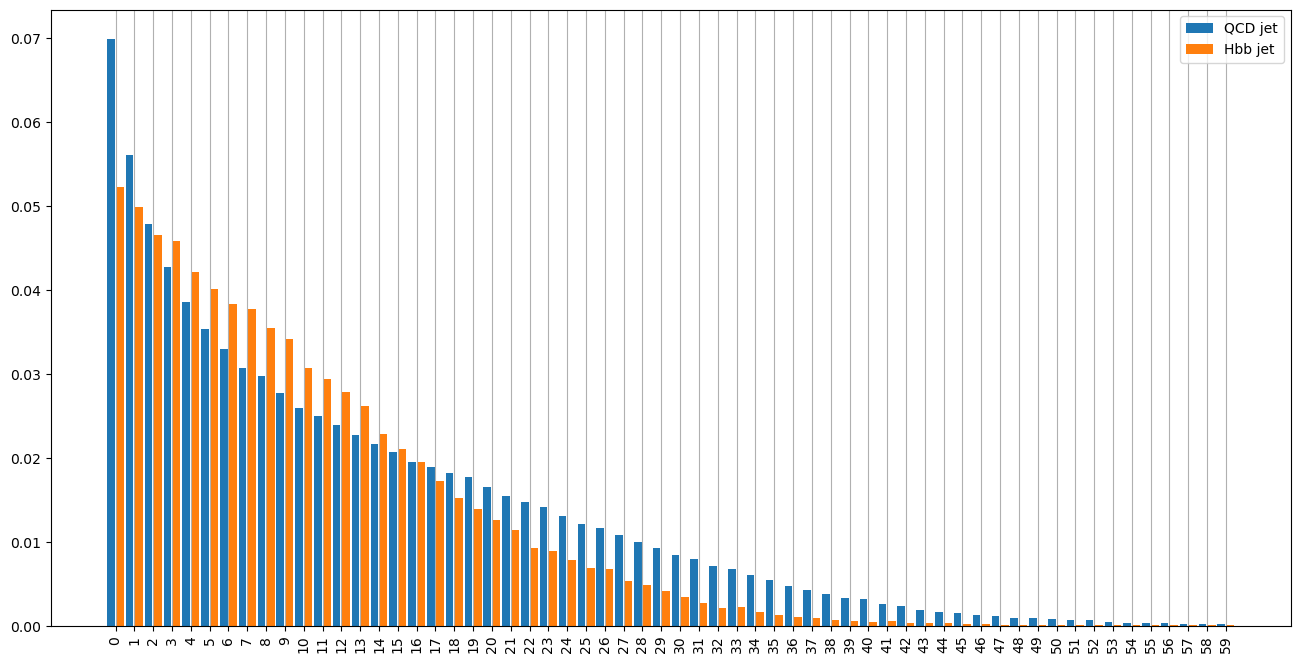

In [112]:
plt.figure(figsize=(16,8))
pos = 2*np.arange(60)
plt.bar(pos, torch.sum(Pall_0, 0).numpy(), align='center', label = 'QCD jet')
plt.bar(pos + 1, torch.sum(Pall_1, 0).numpy(), align='center', label = 'Hbb jet')
plt.xticks(pos + 0.5, list(map(int, pos/2)), rotation='vertical')
plt.grid(axis='x')
plt.legend()
plt.savefig("plots_xAI/track_tracks_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
pos = 2*np.arange(60 + 5)
plt.bar(pos, 
        np.append(torch.sum(Pall_0, 0).reshape(-1).numpy(), torch.sum(Vall_0, 0).reshape(-1).numpy()), 
        align='center', label = 'QCD jet')
plt.bar(pos + 1, 
        np.append(torch.sum(Pall_1, 0).reshape(-1).numpy(), torch.sum(Vall_1, 0).reshape(-1).numpy()),
        align='center', label = 'Hbb jet')
xticklabels = ['track_{}'.format(i) for i in range(60)] + \
              ['sv_{}'.format(i) for i in range(5)] 
# plt.xticks(pos + 0.5, list(map(int, pos/2)), rotation='vertical')
plt.xticks(pos + 0.5, xticklabels, rotation='vertical')
plt.grid(axis='x')
plt.legend()
plt.savefig("plots_xAI/trackNverts_LRP_{}.png".format(tag),bbox_inches='tight')
plt.show()

In [ ]:
ptrels = training_sv[:,0,:].reshape(-1)
erels = training_sv[:,1,:].reshape(-1)
pts = training_sv[:,5,:].reshape(-1)
np.corrcoef(np.array([ptrels, erels, pts]))

In [ ]:
plt.scatter(ptrels, pts)
plt.show()

In [ ]:
plt.scatter(erels, pts)
plt.show()

In [ ]:
plt.scatter(ptrels, erels)
plt.show()

In [ ]:
ordered_tags = [ 'fr1', 'fr2',  'fr3', 'fr1_pv', 'fr2_pv', 'fr3_pv', 'fo1', 'fo2', 'fo3']
HiddenRelevance_0_ord = []
HiddenRelevance_1_ord = []
for _tag in ordered_tags:
    idx = tags.index(_tag)
    HiddenRelevance_0_ord.append(HiddenRelevance_0[idx])
    HiddenRelevance_1_ord.append(HiddenRelevance_1[idx])
tags = ordered_tags
HiddenRelevance_0 = HiddenRelevance_0_ord
HiddenRelevance_1 = HiddenRelevance_1_ord
for ii in range(len(HiddenRelevance_0)):
    print(tags[ii], HiddenRelevance_0[ii].shape, HiddenRelevance_0[ii].sum()/count_0)
    print(tags[ii], HiddenRelevance_1[ii].shape, HiddenRelevance_1[ii].sum()/count_1)

In [ ]:
def ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline'):
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    print(np.max(FiringMatrix_0), np.max(FiringMatrix_1))
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)
#     FiringMatrix_0 = FiringMatrix_0/FiringMatrix_0.max(axis=1).reshape(-1,1)
#     FiringMatrix_1 = FiringMatrix_1/FiringMatrix_1.max(axis=1).reshape(-1,1)

    
    weights = np.append(-1*FiringMatrix_0.reshape(-1), FiringMatrix_1.reshape(-1)) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    x = np.append(x, np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.75)
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    y = np.append(y,y)
    
    fig, axes = plt.subplots(1,2,figsize=(12,6))
    _,_,_,im = axes[0].hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,0.5), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1)
    axes[0].set_facecolor('black')
#     im.cmap.set_under('black')
#     im.cmap.set_over('black')
    fig.colorbar(im, ax=axes[0])
    axes[0].set_xlabel('Network Activation Layers')
    axes[0].set_ylabel('Node in hidden layer')
    axes[0].set_title('NAP ({})'.format(tag))
    axes[0].set_xticks(np.arange(N_cols) + 0.5)
    axes[0].set_xticklabels(layer_tags, rotation='vertical')
    
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    _,_,_,im = axes[1].hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds')

    fig.colorbar(im, ax=axes[1])
    axes[1].set_facecolor('black')
    axes[1].set_xlabel('Network Activation Layers')
    axes[1].set_ylabel('Node in hidden layer')
    axes[1].set_title('Diff. NAP')
    axes[1].set_xticks(np.arange(N_cols) + 0.5)
    axes[1].set_xticklabels(layer_tags, rotation='vertical')

    plt.show()

In [ ]:
ActivationMapPlotter(HiddenRelevance_0, HiddenRelevance_1, tags, tag='baseline')